In [1]:
!pip install tensorflow

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential,load_model

#U-net only
from tensorflow.keras.layers import Input,Conv2DTranspose,concatenate
from tensorflow.keras.models import Model

import tensorflow as tf

import numpy as np
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score
from sklearn.model_selection import train_test_split
import random

Resizing images to 256 for faster computation, original size of 512 may give better results

In [3]:
main_path = '/content/drive/MyDrive/brain tumor segmentation and classification/DATASET/Segmentation'
seg_classes = ['Glioma','Meningioma','Pituitary tumor']
SEG_IMG_SIZE = 256

Creating data frame with image paths and labels

In [4]:
def add_mask(x):
    nsplit = x.split('.')
    fname = nsplit[0] + '_mask.' + nsplit[1]
    return fname

dict_aux = {'filepath':[],'label':[],'encoded_label':[]}
for c in seg_classes:
    class_path = os.path.join(main_path,c)
    encoded_label = seg_classes.index(c) #Match the id from the classification model above
    for fn in os.listdir(class_path):
        dict_aux['filepath'].append( os.path.join(class_path,fn) )
        dict_aux['label'].append(c)
        dict_aux['encoded_label'].append(encoded_label)

seg_df = pd.DataFrame(dict_aux)
seg_df = seg_df.loc[ ~seg_df.filepath.str.contains('_mask')].copy()
seg_df.reset_index(inplace=True)
seg_df['maskpath'] = seg_df.filepath.apply(add_mask)
seg_df = seg_df.sample(frac=1)

In [5]:
train_seg, test_seg = train_test_split(seg_df,test_size=0.15,random_state=99)

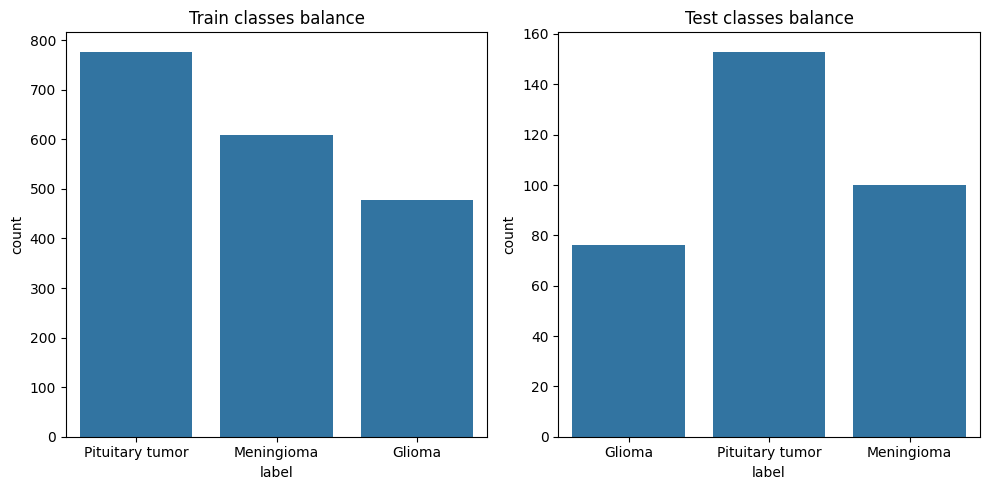

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(x = train_seg.label)
plt.title('Train classes balance')

plt.subplot(1,2,2)
sns.countplot(x = test_seg.label)
plt.title('Test classes balance')

plt.tight_layout()
plt.show()

In [7]:
len(test_seg),len(train_seg)

(329, 1863)

In [8]:
train_paths_input = train_seg.filepath.tolist()
train_paths_output = train_seg.maskpath.tolist()
train_classes_seg = train_seg.encoded_label.tolist()

test_paths_input = test_seg.filepath.tolist()
test_paths_output = test_seg.maskpath.tolist()
test_classes_seg = test_seg.encoded_label.tolist()

In [41]:
def load_and_preprocess_image_seg(input_path_, output_path_, training=True):
    input_image = tf.io.read_file(input_path_)
    input_image = tf.image.decode_png(input_image,channels=1)

    if output_path_ is not None:
        output_image = tf.io.read_file(output_path_)
        output_image = tf.image.decode_png(output_image,channels=1)
        output_image = tf.cast(output_image, tf.float32) / 255.0
    else:
        output_image = tf.zeros((tf.shape(input_image)[0], tf.shape(input_image)[1], 1), dtype=tf.float32)


    input_image = tf.cast(input_image, tf.float32) / 255.0


    if training:
       input_image,output_image = augment_image_seg(input_image,output_image)

    input_image = tf.image.resize(input_image, [SEG_IMG_SIZE, SEG_IMG_SIZE])
    output_image = tf.image.resize(output_image, [SEG_IMG_SIZE, SEG_IMG_SIZE])

    #Binarize mask after resizing
    output_image = tf.cast(output_image > 0.15, tf.float32)

    return input_image,output_image

def augment_image_seg(input_image,output_image):
    if tf.random.uniform([]) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        output_image = tf.image.flip_left_right(output_image)
    if tf.random.uniform([]) > 0.5:
        input_image = tf.image.flip_up_down(input_image)
        output_image = tf.image.flip_up_down(output_image)
    if tf.random.uniform([]) > 0.5:
        k_rot = tf.random.uniform([],minval=1,maxval=4,dtype=tf.int32)
        input_image = tf.image.rot90(input_image,k=k_rot)
        output_image = tf.image.rot90(output_image,k=k_rot)
    return input_image,output_image

In [10]:
BATCH_SIZE = 16#32

train_ds_seg = tf.data.Dataset.from_tensor_slices((train_paths_input, train_paths_output))
train_ds_seg = train_ds_seg.map(
    lambda x, y: load_and_preprocess_image_seg(x, y, training=True),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_ds_seg = train_ds_seg.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds_seg = tf.data.Dataset.from_tensor_slices((test_paths_input, test_paths_output))
test_ds_seg = test_ds_seg.map(
    lambda x, y: load_and_preprocess_image_seg(x, y, training=False),
    num_parallel_calls=tf.data.AUTOTUNE
)
test_ds_seg = test_ds_seg.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Tried this basic encoder decored architecture before, and after tried a u-net bellow

In [11]:
inputs = Input((SEG_IMG_SIZE,SEG_IMG_SIZE,1))

# Encoder (Downsampling)
c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
c1 = Conv2D(32, 3, activation='relu', padding='same')(c1)
p1 = MaxPool2D()(c1)

c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
c2 = Conv2D(64, 3, activation='relu', padding='same')(c2)
p2 = MaxPool2D()(c2)

c3 = Conv2D(128, 3, activation='relu', padding='same')(p2)
c3 = Conv2D(128, 3, activation='relu', padding='same')(c3)
p3 = MaxPool2D()(c3)

c4 = Conv2D(256, 3, activation='relu', padding='same')(p3)
c4 = Conv2D(256, 3, activation='relu', padding='same')(c4)
p4 = MaxPool2D()(c4)

# Bottleneck
c5 = Conv2D(512, 3, activation='relu', padding='same')(p4)
c5 = Conv2D(512, 3, activation='relu', padding='same')(c5)

# Decoder (Upsampling)
u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, 3, activation='relu', padding='same')(u6)
c6 = Conv2D(256, 3, activation='relu', padding='same')(c6)

u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, 3, activation='relu', padding='same')(u7)
c7 = Conv2D(128, 3, activation='relu', padding='same')(c7)

u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, 3, activation='relu', padding='same')(u8)
c8 = Conv2D(64, 3, activation='relu', padding='same')(c8)

u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, 3, activation='relu', padding='same')(u9)
c9 = Conv2D(32, 3, activation='relu', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

model_seg = Model(inputs=[inputs], outputs=[outputs])
model_seg.compile(optimizer = Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [12]:
model_seg.fit(train_ds_seg,validation_data=test_ds_seg, epochs = 20)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 664s 3s/step - accuracy: 0.9803 - loss: 0.1979 - val_accuracy: 0.9824 - val_loss: 0.0744
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 47s 315ms/step - accuracy: 0.9829 - loss: 0.0730 - val_accuracy: 0.9824 - val_loss: 0.0751
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 46s 304ms/step - accuracy: 0.9825 - loss: 0.0740 - val_accuracy: 0.9824 - val_loss: 0.0700
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 46s 308ms/step - accuracy: 0.9824 - loss: 0.0681 - val_accuracy: 0.9824 - val_loss: 0.0639
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 45s 305ms/step - accuracy: 0.9824 - loss: 0.0642 - val_accuracy: 0.9824 - val_loss: 0.0627
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 85s 318ms/step - accuracy: 0.9829 - loss: 0.0621 - val_accuracy: 0.9824 - val_loss: 0.0614
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 45s 306ms/step - accuracy: 0.9829 - loss: 0.0591 - val_accuracy: 0.9824 - val_loss: 0.0581
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 49s 332ms/step - accuracy: 0.9828 - loss: 0.0

In [22]:
model_seg.save('segmentation_unet.h5')

In [14]:
y_pred = model_seg.predict(test_ds_seg)
y_pred = (y_pred > 0.5).astype(np.uint8)

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step


In [15]:
y_true = []
for _, y_true_ in test_ds_seg:
    y_true.append(y_true_.numpy())
y_true = np.concatenate(y_true, axis=0)

In [16]:
accuracy_score(y_true.flatten(), y_pred.flatten())

0.9896084863726491

In [17]:
f1_score(y_true.flatten(), y_pred.flatten())

0.6549937405974227

In [18]:
confusion_matrix(y_true.flatten(), y_pred.flatten())

array([[21124605,    57526],
       [  166529,   212684]])

In [19]:
model_seg = load_model('segmentation.h5')

In [25]:
def visualize_results(n,source='test'):
    for _ in range(n):
        if source == 'test':
            img_input_paths = test_paths_input
            img_output_paths = test_paths_output
            type_labels = test_classes_seg
        else:
            img_input_paths = train_paths_input
            img_output_paths = train_paths_output
            type_labels = train_classes_seg

        img_pick = random.randint(0,len(img_input_paths)-1)

        img_input_path = img_input_paths[img_pick]
        img_output_path = img_output_paths[img_pick]
        type_label = type_labels[img_pick]

        img_inp,img_out = load_and_preprocess_image_seg(img_input_path, img_output_path, training=False)
        img_inp = tf.expand_dims(img_inp, axis=0)
        img_pred = model_seg.predict(img_inp)
        img_pred_bin = (img_pred[0] > 0.5).astype(np.uint8)


        plt.figure(figsize=(10,5))
        plt.subplot(1,3,1)
        plt.title(f'Original image {seg_classes[type_label]}')
        plt.imshow(img_inp[0],cmap='gray')
        plt.grid(False)
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(img_inp[0],cmap='gray')
        plt.imshow(img_out,cmap='Reds',alpha=img_out[:,:,0]/2)
        plt.grid(False)
        plt.axis('off')
        plt.title(f'Expected area detection')

        plt.subplot(1,3,3)
        plt.imshow(img_inp[0],cmap='gray')
        plt.imshow(img_pred_bin,cmap='Reds',alpha=img_pred_bin[:,:,0]/2)
        plt.grid(False)
        plt.axis('off')
        plt.title(f'Area detected')

        plt.tight_layout()
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


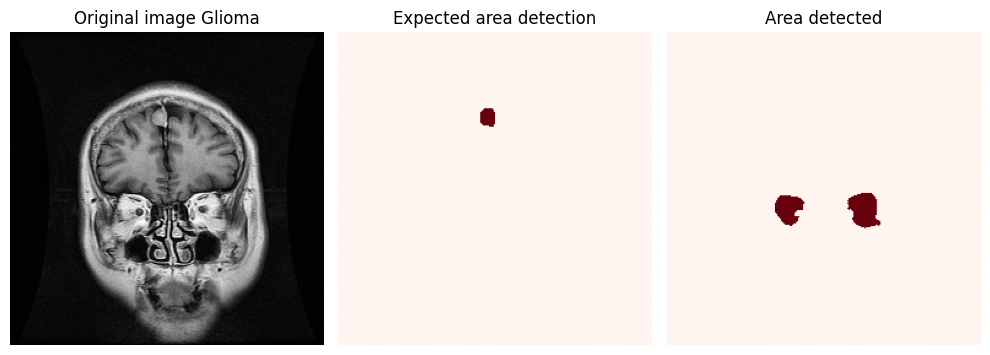

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


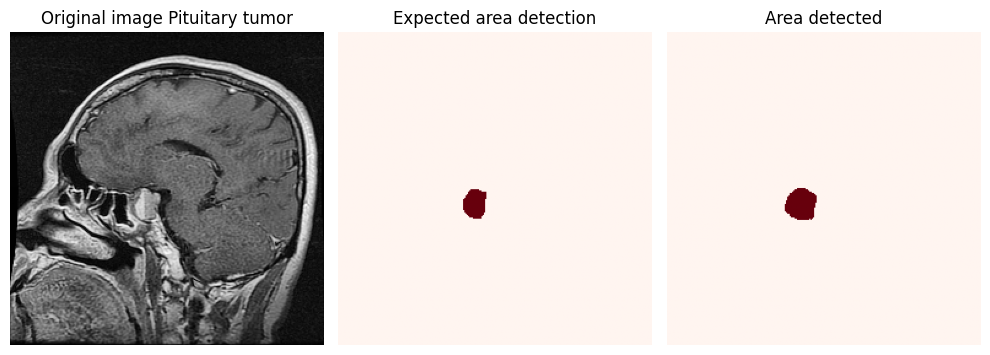

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


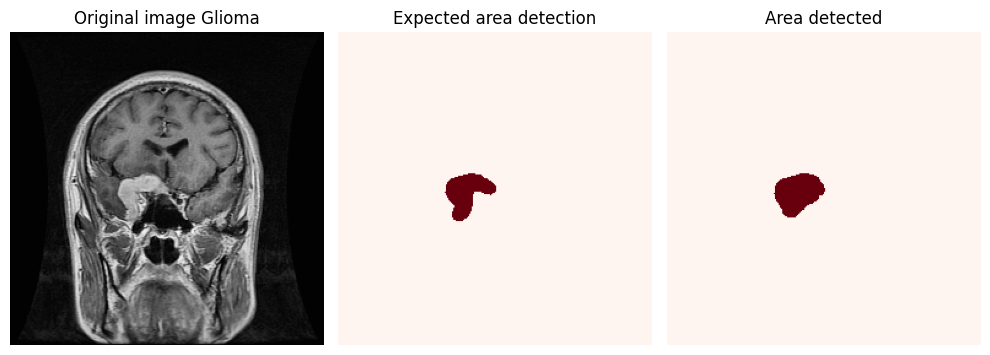

In [26]:
visualize_results(3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


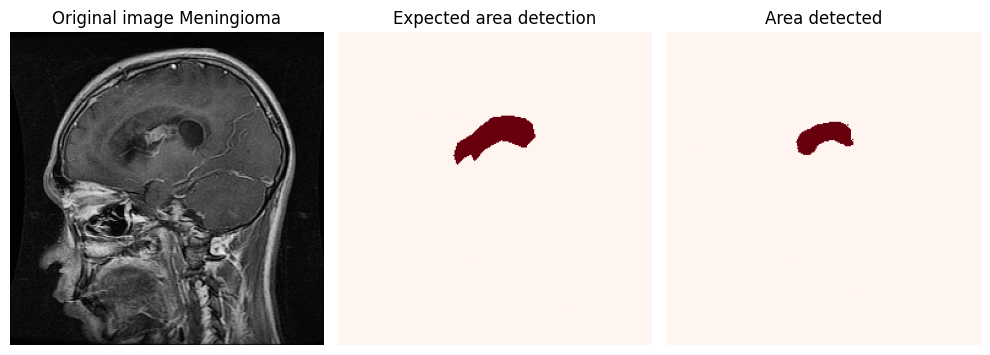

In [28]:
visualize_results(1)

In [29]:

import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

def visualize_results(n, source='test'):
    for _ in range(n):
        if source == 'test':
            img_input_paths = test_paths_input
            img_output_paths = test_paths_output
            type_labels = test_classes_seg
        else:
            img_input_paths = train_paths_input
            img_output_paths = train_paths_output
            type_labels = train_classes_seg

        img_pick = random.randint(0, len(img_input_paths) - 1)

        img_input_path = img_input_paths[img_pick]
        img_output_path = img_output_paths[img_pick]
        type_label = type_labels[img_pick]

        # Load and preprocess images
        img_inp, img_out = load_and_preprocess_image_seg(img_input_path, img_output_path, training=False)
        img_inp_expanded = tf.expand_dims(img_inp, axis=0)

        # Predict segmentation mask
        img_pred = model_seg.predict(img_inp_expanded)
        img_pred_bin = (img_pred[0] > 0.5).astype(np.uint8)

        plt.figure(figsize=(12, 4))

        # Original image
        plt.subplot(1, 3, 1)
        plt.title(f'Original image {seg_classes[type_label]}')
        plt.imshow(img_inp, cmap='gray')
        plt.axis('off')

        # Expected area detection overlay
        plt.subplot(1, 3, 2)
        plt.title('Expected area detection')
        plt.imshow(img_inp, cmap='gray')
        plt.imshow(img_out[..., 0], cmap='Reds', alpha=0.5)  # Assuming single channel mask
        plt.axis('off')

        # Predicted area detection overlay
        plt.subplot(1, 3, 3)
        plt.title('Area detected')
        plt.imshow(img_inp, cmap='gray')
        plt.imshow(img_pred_bin[..., 0], cmap='Reds', alpha=0.5)  # Assuming single channel mask
        plt.axis('off')

        plt.tight_layout()
        plt.show()


In [36]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

def visualize_results(n, source='test'):
    img_inp_list = []
    img_pred_bin_list = []
    for i in range(n):
        if source == 'test':
            img_input_paths = test_paths_input
            img_output_paths = test_paths_output
            type_labels = test_classes_seg
        else:
            img_input_paths = train_paths_input
            img_output_paths = train_paths_output
            type_labels = train_classes_seg

        img_pick = random.randint(0, len(img_input_paths) - 1)

        img_input_path = img_input_paths[img_pick]
        img_output_path = img_output_paths[img_pick]
        type_label = type_labels[img_pick]

        # Load and preprocess images
        img_inp, img_out = load_and_preprocess_image_seg(img_input_path, img_output_path, training=False)
        img_inp_expanded = tf.expand_dims(img_inp, axis=0)

        # Debug prints
        print(f"Sample {i+1}")
        print(f"Image input shape: {img_inp.shape}")
        print(f"Output mask shape: {img_out.shape}")

        # Predict segmentation mask
        img_pred = model_seg.predict(img_inp_expanded)
        img_pred_bin = (img_pred[0] > 0.5).astype(np.uint8)
        print(f"Prediction mask shape: {img_pred_bin.shape}")
        print(f"Unique values in prediction mask: {np.unique(img_pred_bin)}")

        plt.figure(figsize=(12, 4))

        # Original image
        plt.subplot(1, 3, 1)
        plt.title(f'Original image {seg_classes[type_label]}')
        plt.imshow(img_inp, cmap='gray')
        plt.axis('off')

        # Expected area detection overlay
        plt.subplot(1, 3, 2)
        plt.title('Expected area detection')
        plt.imshow(img_inp, cmap='gray')
        plt.imshow(img_out[..., 0], cmap='Reds', alpha=0.5)
        plt.axis('off')

        # Predicted area detection overlay
        plt.subplot(1, 3, 3)
        plt.title('Area detected')
        plt.imshow(img_inp, cmap='gray')
        plt.imshow(img_pred_bin[..., 0], cmap='Reds', alpha=0.5)
        plt.axis('off')

        plt.tight_layout()
        plt.show()
        img_inp_list.append(img_inp)
        img_pred_bin_list.append(img_pred_bin)
    return img_inp_list, img_pred_bin_list

Sample 1
Image input shape: (256, 256, 1)
Output mask shape: (256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction mask shape: (256, 256, 1)
Unique values in prediction mask: [0 1]


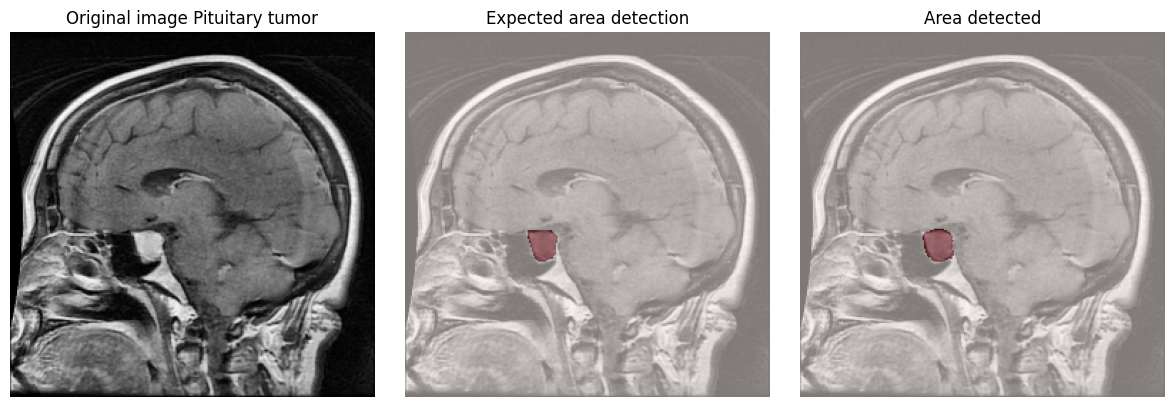

In [31]:
visualize_results(1, source='test')


Sample 1
Image input shape: (256, 256, 1)
Output mask shape: (256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction mask shape: (256, 256, 1)
Unique values in prediction mask: [0 1]


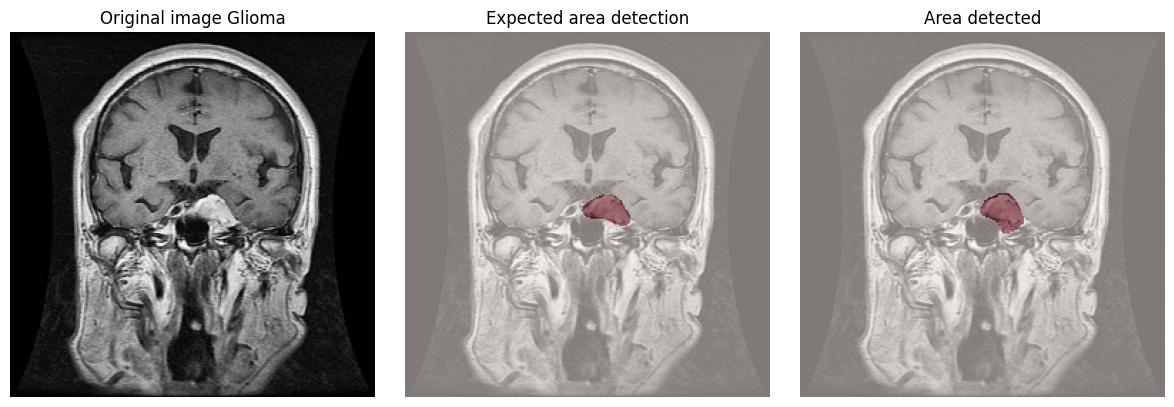

In [37]:
import matplotlib.patches as patches

# Call visualize_results to get img_pred_bin and img_inp
img_inp_list, img_pred_bin_list = visualize_results(1, source='test')
img_inp = img_inp_list[0]
img_pred_bin = img_pred_bin_list[0]

# After you get img_pred_bin[..., 0], find bbox coords:
mask = img_pred_bin[..., 0]

ys, xs = np.where(mask == 1)
if ys.size > 0 and xs.size > 0:
    y_min, y_max = ys.min(), ys.max()
    x_min, x_max = xs.min(), xs.max()
else:
    # If mask is empty, set default bbox (or skip)
    y_min = x_min = y_max = x_max = 0

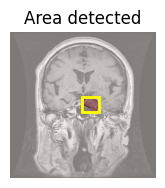

In [38]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

ax = plt.subplot(1, 3, 3)
plt.title('Area detected')
plt.imshow(img_inp, cmap='gray')
plt.imshow(mask, cmap='Reds', alpha=0.5)
plt.axis('off')

if ys.size > 0 and xs.size > 0:
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             linewidth=2, edgecolor='yellow', facecolor='none')
    ax.add_patch(rect)

In [39]:
def segment_and_overlay(img_input_path):
    img_inp, _ = load_and_preprocess_image_seg(img_input_path, None, training=False)  # No ground truth needed here
    img_inp_expanded = tf.expand_dims(img_inp, axis=0)

    img_pred = model_seg.predict(img_inp_expanded)
    img_pred_bin = (img_pred[0] > 0.5).astype(np.uint8)[..., 0]

    # Create overlay
    plt.figure(figsize=(6, 6))
    plt.imshow(img_inp, cmap='gray')
    plt.imshow(img_pred_bin, cmap='Reds', alpha=0.5)
    plt.axis('off')

    # Draw bounding box
    ys, xs = np.where(img_pred_bin == 1)
    if ys.size > 0 and xs.size > 0:
        y_min, y_max = ys.min(), ys.max()
        x_min, x_max = xs.min(), xs.max()
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='yellow', facecolor='none')
        plt.gca().add_patch(rect)

    plt.title('Segmented output with bounding box')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


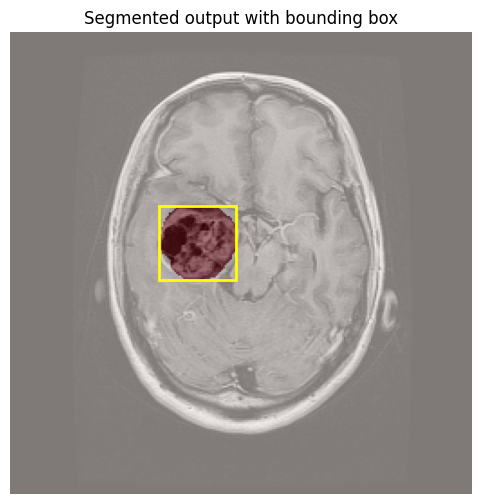

In [42]:
segment_and_overlay('/content/drive/MyDrive/brain tumor segmentation and classification/DATASET/Segmentation/Glioma/enh_1841.png')


In [45]:
import os

# Your class names must match folder names exactly or map accordingly:
folder_to_class_index = {
    'Glioma': 0,
    'Meningioma': 1,
    'Pituitary tumor': 2
}

def get_tumor_class_from_path(img_path):
    # Extract the parent folder name containing the image
    parent_folder = os.path.basename(os.path.dirname(img_path))
    return folder_to_class_index.get(parent_folder, None)


In [47]:
def segment_and_overlay(img_input_path):
    tumor_class_label = get_tumor_class_from_path(img_input_path)

    img_inp, _ = load_and_preprocess_image_seg(img_input_path, None, training=False)
    img_inp_expanded = tf.expand_dims(img_inp, axis=0)

    img_pred = model_seg.predict(img_inp_expanded)
    img_pred_bin = (img_pred[0] > 0.5).astype(np.uint8)[..., 0]

    plt.figure(figsize=(6, 6))
    plt.imshow(img_inp, cmap='gray')
    plt.imshow(img_pred_bin, cmap='Reds', alpha=0.5)
    plt.axis('off')

    ys, xs = np.where(img_pred_bin == 1)
    if ys.size > 0 and xs.size > 0:
        y_min, y_max = ys.min(), ys.max()
        x_min, x_max = xs.min(), xs.max()
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='yellow', facecolor='none')
        plt.gca().add_patch(rect)

    if tumor_class_label is not None:
        plt.title(f'Segmented output: {seg_classes[tumor_class_label]}')
    else:
        plt.title('Segmented output with bounding box')

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


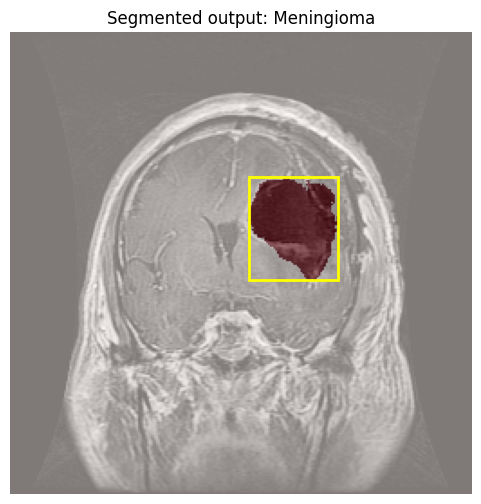

In [48]:
segment_and_overlay('/content/drive/MyDrive/brain tumor segmentation and classification/DATASET/Segmentation/Meningioma/enh_1.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


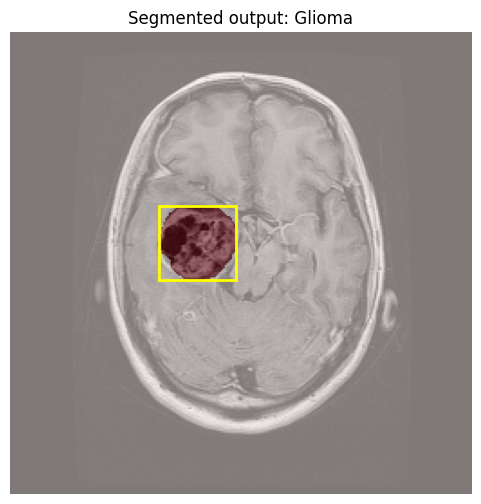

In [52]:
segment_and_overlay('/content/drive/MyDrive/brain tumor segmentation and classification/DATASET/Segmentation/Glioma/enh_1841.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


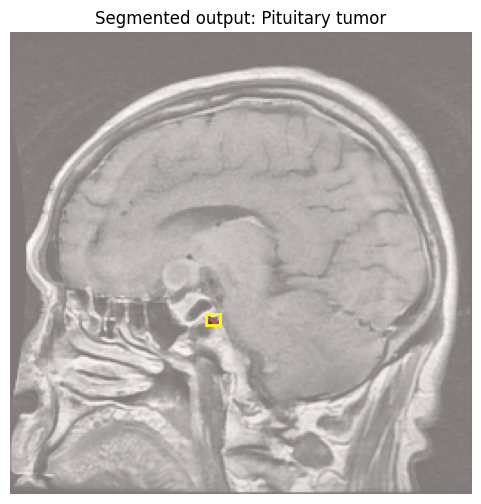

In [53]:
segment_and_overlay('/content/drive/MyDrive/brain tumor segmentation and classification/DATASET/Segmentation/Pituitary tumor/enh_1000.png')
